# Building the prediction model with PCA run dataframe and Random Forest

This is an alternative model being explored where the features are principal components derived from the initial workbook. This will be used to compare performance of the logistic regression model which was developed first for more interpretability

## imports

In [18]:
# import manual_run_prem
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/pca_run_prem.csv')

In [19]:
df.sample(5)

,PC1,PC2,PC3,p(Home),p(Draw),p(Away),Result
2382,-1.378063,-0.660772,1.551522,0.457,0.258,0.285,1
152,-0.282983,-0.927106,-1.027825,0.457,0.258,0.285,1
1836,-0.107163,-1.260347,0.130567,0.457,0.258,0.285,1
2959,-1.478656,-0.244540,0.085777,0.457,0.258,0.285,-1
2079,0.823136,0.240707,0.435631,0.457,0.258,0.285,1


## Train the model

In [20]:
# Step 1: Split data into features (X) and target (y)
X_pca = df.drop('Result', axis=1)
y_pca = df['Result']

In [21]:
# Step 2: Train-test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [22]:
# Step 3: Train Decision Tree Classifier
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # You can tune max_depth
tree_model.fit(X_train_pca, y_train_pca)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [23]:
# Step 4: Evaluate the model
y_pred_pca_tree = tree_model.predict(X_test_pca)

In [24]:
# Accuracy and classification report
print("PCA Run Decision Tree:")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca_tree))
print(classification_report(y_test_pca, y_pred_pca_tree))

PCA Run Decision Tree:
Accuracy: 0.5032894736842105
              precision    recall  f1-score   support

          -1       0.43      0.60      0.50       177
           0       0.33      0.03      0.06       152
           1       0.57      0.70      0.62       279

    accuracy                           0.50       608
   macro avg       0.44      0.44      0.39       608
weighted avg       0.47      0.50      0.45       608



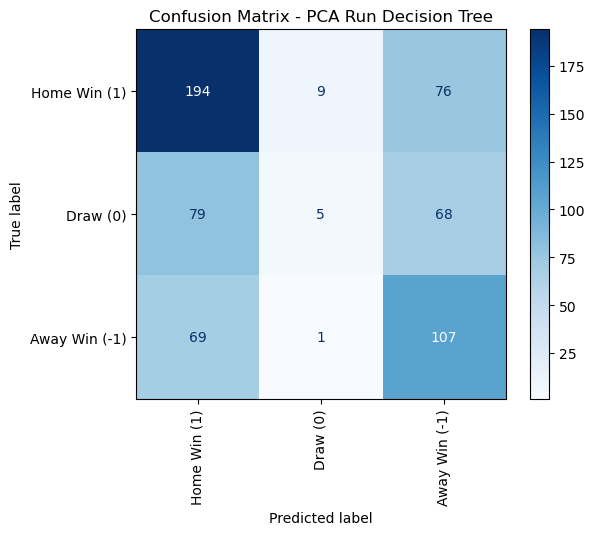

In [25]:
# Step 5: Confusion Matrix
cm_pca_tree = confusion_matrix(y_test_pca, y_pred_pca_tree, labels=[1, 0, -1])
disp_pca_tree = ConfusionMatrixDisplay(confusion_matrix=cm_pca_tree, display_labels=['Home Win (1)', 'Draw (0)', 'Away Win (-1)'])
disp_pca_tree.plot(cmap='Blues', xticks_rotation='vertical')
disp_pca_tree.ax_.set_title("Confusion Matrix - PCA Run Decision Tree")
plt.show()

In [26]:
# print the cm
print(cm_pca_tree)


[[194   9  76]
 [ 79   5  68]
 [ 69   1 107]]


## Initial analysis

With chance being 0.33, the initial performance of 50.33% is slightly worse than the logistic regression but its performance differs in that:
- It is slightly stronger in predicting away wins
- It is slightly weaker in predicting home wins
- It is willing to bet on draws occurring

The recall scores being higher than the precision scores shows that we will get a lot of false positives for the home win or away win.

However...**it is struggling with draws**